In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [15]:
df = pd.read_csv('gdp_population_with_lags.csv')

In [16]:
lag_years = [1, 2, 3]
for lag in lag_years:
    df[f"GDP_lag_{lag}"] = df.groupby("Country Name")["GDP"].shift(lag)

# Growth and per capita
df["GDP_per_capita"] = df["GDP"] / df["Population"]
df["GDP_growth_1yr"] = df.groupby("Country Name")["GDP"].pct_change()
df["Population_growth_1yr"] = df.groupby("Country Name")["Population"].pct_change()

# ===============================
# 5️ Handle NaNs
# ===============================
# Drop initial years with NaN in lag features
df = df.dropna(subset=["GDP_lag_1","GDP_lag_2","GDP_lag_3","Population","GDP"])

# Optional: fill small NaNs in growth/per capita
df["GDP_growth_1yr"] = df["GDP_growth_1yr"].fillna(0)
df["Population_growth_1yr"] = df["Population_growth_1yr"].fillna(0)
df["GDP_per_capita"] = df["GDP_per_capita"].fillna(df["GDP"]/df["Population"])

# ===============================
# 6️ Select features and target
# ===============================
features = ["Population", "GDP_lag_1","GDP_lag_2","GDP_lag_3","GDP_growth_1yr","Population_growth_1yr","GDP_per_capita"]
target = "GDP"

# ===============================
# 7️ Split train/test (time-aware)
# ===============================
train = df[df["Year"] <= 2014]
test = df[df["Year"] > 2014]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# ===============================
# 8️ Train Linear Regression
# ===============================
lr = LinearRegression()
lr.fit(X_train, y_train)

# ===============================
# 9️ Evaluate model
# ===============================
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

# ===============================
# 10 Forecast GDP 2019–2030
# ===============================
future_years = range(2019, 2024)
results = []

# Use last available row per country
last_rows = df.groupby("Country Name").tail(1)

for year in future_years:
    new_rows = []
    for _, row in last_rows.iterrows():
        new_row = row.copy()
        new_row["Year"] = year
        
        # Predict GDP
        X_input = new_row[features].values.reshape(1, -1)
        pred_gdp = lr.predict(X_input)[0]
        
        # Update lag features for next iteration
        new_row["GDP_lag_3"] = new_row["GDP_lag_2"]
        new_row["GDP_lag_2"] = new_row["GDP_lag_1"]
        new_row["GDP_lag_1"] = pred_gdp
        new_row["GDP_growth_1yr"] = (pred_gdp - new_row["GDP_lag_2"]) / new_row["GDP_lag_2"]
        
        results.append({
            "Country Name": row["Country Name"],
            "Year": year,
            "Predicted_GDP": pred_gdp
        })
        new_rows.append(new_row)
    
    last_rows = pd.DataFrame(new_rows)

future_df = pd.DataFrame(results)

# ===============================
# 11 Top 10 GDP countries in 2030
# ===============================
top10_gdp_2030 = future_df[future_df["Year"]==2023].sort_values("Predicted_GDP", ascending=False).head(10)
print("Top 10 GDP countries predicted for 2023:")
print(top10_gdp_2030)

Train MAE: 15788418979.553387
Test MAE: 26766263744.50861
Train R²: 0.9969503329136251
Test R²: 0.9977393346663708


c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\val

Top 10 GDP countries predicted for 2023:
           Country Name  Year  Predicted_GDP
805       United States  2023   2.387694e+13
679               China  2023   1.642614e+13
725               Japan  2023   5.810275e+12
703             Germany  2023   4.634340e+12
717               India  2023   4.358223e+12
804      United Kingdom  2023   3.277616e+12
699              France  2023   3.192784e+12
667              Brazil  2023   2.744581e+12
723               Italy  2023   2.425623e+12
772  Russian Federation  2023   2.148790e+12


c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Dewmith\Downloads\greenhouse-predictor_new\venv\Lib\site-packages\sklearn\utils\val

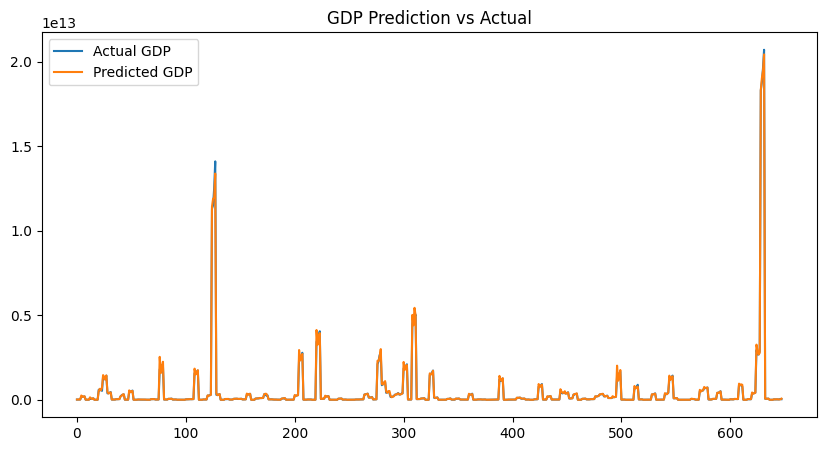

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual GDP")
plt.plot(y_test_pred, label="Predicted GDP")
plt.legend()
plt.title("GDP Prediction vs Actual")
plt.show()


In [18]:
import joblib

# Save the model
joblib.dump(lr, 'gdp_linear_regression_model.pkl')

print("Model saved successfully!")

Model saved successfully!


In [19]:
# ===============================
#  Generate GDP predictions up to 2024 with real population
# ===============================

# Load the original data and population data
df_original = pd.read_csv('gdp_population_with_lags.csv')
pop_df = pd.read_csv('population_long_1980_2024.csv')

# Find the last year with actual GDP data per country
last_gdp_year = df_original.groupby("Country Name")["Year"].max().to_dict()

# Get unique countries
countries = df_original["Country Name"].unique()

# Prepare features (same as training)
features = ["Population", "GDP_lag_1", "GDP_lag_2", "GDP_lag_3", 
            "GDP_growth_1yr", "Population_growth_1yr", "GDP_per_capita"]

# Store all predictions
all_predictions = []

for country in countries:
    # Get this country's data
    country_df = df_original[df_original["Country Name"] == country].sort_values("Year")
    country_pop = pop_df[pop_df["Country Name"] == country].set_index("Year")["Population"].to_dict()
    
    if country_df.empty:
        continue
    
    # Get country code
    country_code = country_df["Country Code"].iloc[0]
    
    # Get the last row with actual data
    last_row = country_df.iloc[-1].copy()
    last_year = int(last_row["Year"])
    
    # Predict for years from last_year+1 to 2024
    for year in range(last_year + 1, 2025):
        # Get real population if available
        if year in country_pop:
            new_population = country_pop[year]
        else:
            # Use last known population if not available
            new_population = last_row["Population"]
        
        # Calculate population growth
        pop_growth = (new_population - last_row["Population"]) / last_row["Population"] if last_row["Population"] != 0 else 0
        
        # Update population
        last_row["Population"] = new_population
        last_row["Population_growth_1yr"] = pop_growth
        
        # Update GDP per capita (using previous GDP for calculation)
        last_row["GDP_per_capita"] = last_row["GDP_lag_1"] / new_population if new_population != 0 else 0
        
        # Predict GDP
        X_input = pd.DataFrame([last_row[features]])
        pred_gdp = lr.predict(X_input)[0]
        
        # Store the prediction
        all_predictions.append({
            "Country Name": country,
            "Country Code": country_code,
            "Year": year,
            "GDP": pred_gdp,
            "Population": new_population,
            "GDP_lag_1": last_row["GDP_lag_1"],
            "GDP_lag_2": last_row["GDP_lag_2"],
            "GDP_lag_3": last_row["GDP_lag_3"],
            "GDP_growth_1yr": last_row["GDP_growth_1yr"],
            "Population_growth_1yr": pop_growth,
            "GDP_per_capita": pred_gdp / new_population if new_population != 0 else 0
        })
        
        # Update lag features for next iteration
        last_row["GDP_lag_3"] = last_row["GDP_lag_2"]
        last_row["GDP_lag_2"] = last_row["GDP_lag_1"]
        last_row["GDP_lag_1"] = pred_gdp
        last_row["GDP_growth_1yr"] = (pred_gdp - last_row["GDP_lag_2"]) / last_row["GDP_lag_2"] if last_row["GDP_lag_2"] != 0 else 0
        last_row["Year"] = year

# Create predictions DataFrame
predictions_df = pd.DataFrame(all_predictions)

# Combine original data with predictions
final_df = pd.concat([df_original, predictions_df], ignore_index=True)
final_df = final_df.sort_values(["Country Name", "Year"]).reset_index(drop=True)

# Save to CSV
final_df.to_csv('gdp_population_predicted_2024.csv', index=False)

print(f"Saved {len(final_df)} rows to gdp_population_predicted_2024.csv")
print(f"Original rows: {len(df_original)}, Predicted rows: {len(predictions_df)}")
print(f"Years covered: {final_df['Year'].min()} - {final_df['Year'].max()}")

Saved 6804 rows to gdp_population_predicted_2024.csv
Original rows: 5832, Predicted rows: 972
Years covered: 1983 - 2024
